In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters for the controlled Lotka–Volterra system
alpha = 0.5
beta = 1 / 40
gamma = 0.5
delta = 1 / 200
dt = 0.1
t = np.arange(0, 50 + dt, dt)
n_steps = len(t)

In [3]:
# Control input u(t)
u = (2 * np.sin(t) * np.sin(t / 10)) ** 2

# State array:   x[0] = prey, x[1] = predator
x = np.empty((2, n_steps))
x[:, 0] = [60.0, 50.0]             # initial condition

In [4]:
def f(state, control):
    """Right‑hand side of the controlled Lotka–Volterra ODEs."""
    x1, x2 = state
    dx1 = alpha * x1 - beta * x1 * x2
    dx2 = -gamma * x2 + delta * x1 * x2 + control
    return np.array([dx1, dx2])

In [5]:
# Forward Euler integration to generate snapshots
for k in range(n_steps - 1):
    x[:, k + 1] = x[:, k] + dt * f(x[:, k], u[k])

# Construct snapshot matrices for the DMDc algorithm
X = x[:, :-1]               # shape (2, 500)
Y = x[:, 1:]                # shape (2, 500)
Gamma = u[:-1].reshape(1, -1)  # shape (1, 500)

# Augmented data matrix
Omega = np.vstack((X, Gamma))

In [12]:
U_tilde, S_tilde, Vh_tilde = np.linalg.svd(Omega, full_matrices=False)
V_tilde = Vh_tilde.T
Sigma_inv = np.diag(1.0 / S_tilde)

print("the shape of U_tilde", U_tilde.shape)
U_tilde1 = U_tilde[:2, :]   # first n rows
U_tilde2 = U_tilde[2:, :]   # last  q rows

the shape of U_tilde (3, 3)


In [7]:
A_bar = Y @ V_tilde @ Sigma_inv @ U_tilde1.T
B_bar = Y @ V_tilde @ Sigma_inv @ U_tilde2.T

U_hat, S_hat, Vh_hat = np.linalg.svd(Y, full_matrices=False)
V_hat = Vh_hat.T

A_tilde = U_hat.T @ A_bar @ U_hat
B_tilde = U_hat.T @ B_bar

eigvals, W = np.linalg.eig(A_tilde)

Phi = Y @ V_tilde @ Sigma_inv @ U_tilde1.T @ U_hat @ W

In [8]:
Y_pred = A_bar @ X + B_bar @ Gamma

rmse1 = np.sqrt(np.mean((Y_pred[0] - Y[0]) ** 2))
rmse2 = np.sqrt(np.mean((Y_pred[1] - Y[1]) ** 2))

print(f"RMSE (prey)     : {rmse1:.4f}")
print(f"RMSE (predator) : {rmse2:.4f}")
print("\nDMDc eigenvalues:")
for lam in eigvals:
    print(f"  {lam:.6f}")

RMSE (prey)     : 1.7231
RMSE (predator) : 0.3446

DMDc eigenvalues:
  0.994578+0.016967j
  0.994578-0.016967j


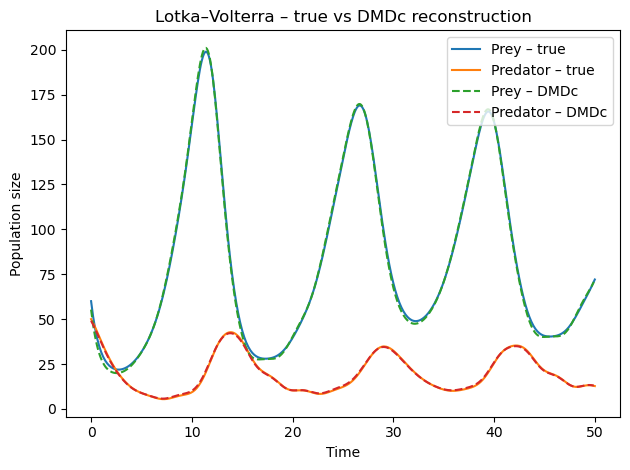

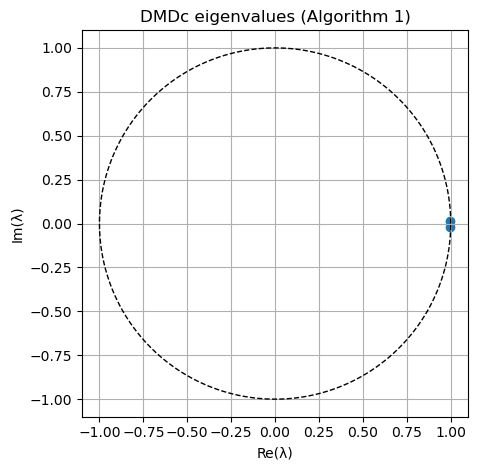

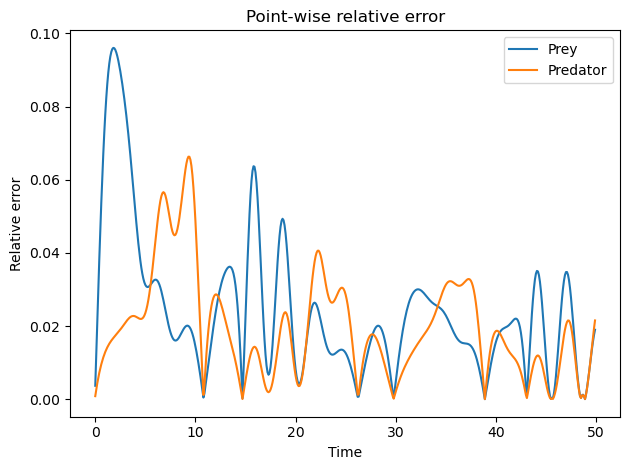

In [9]:
# Visualisations

# 1) True vs predicted trajectories
plt.figure()
plt.plot(t, x[0], label="Prey – true")
plt.plot(t, x[1], label="Predator – true")
plt.plot(t[:-1], Y_pred[0], "--", label="Prey – DMDc")
plt.plot(t[:-1], Y_pred[1], "--", label="Predator – DMDc")
plt.xlabel("Time")
plt.ylabel("Population size")
plt.title("Lotka–Volterra – true vs DMDc reconstruction")
plt.legend()
plt.tight_layout()
plt.show()

# 2) DMDc eigenvalues on the complex plane
plt.figure()
theta = np.linspace(0, 2 * np.pi, 400)
plt.plot(np.cos(theta), np.sin(theta), "k--", linewidth=1)
plt.scatter(eigvals.real, eigvals.imag)
plt.gca().set_aspect("equal", "box")
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title("DMDc eigenvalues (Algorithm 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Relative error over time
rel_err_prey = np.abs(Y[0] - Y_pred[0]) / np.abs(Y[0])
rel_err_pred = np.abs(Y[1] - Y_pred[1]) / np.abs(Y[1])

plt.figure()
plt.plot(t[:-1], rel_err_prey, label="Prey")
plt.plot(t[:-1], rel_err_pred, label="Predator")
plt.xlabel("Time")
plt.ylabel("Relative error")
plt.title("Point‑wise relative error")
plt.legend()
plt.tight_layout()
plt.show()
